In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

In [2]:
def find_eigenvalue(A, v):
    value = A @ v / v
    return value[0]

def dominant_eigen(A, epsilon=0.01):
    '''Returns the dominant eigenvalue and eigenvector of the matrix'''
    n, m = A.shape
    k = min(n, m)
    v = np.ones(k) / np.sqrt(k)
    
    if n > m:
        A = A.T @ A
    elif n < m:
        A = A @ A.T
    
    ev = find_eigenvalue(A, v)

    while True:
        Av = A @ v
        v_new = Av / np.linalg.norm(Av)
        ev_new = find_eigenvalue(A, v_new)
        
        if np.abs(ev - ev_new) < epsilon:
            break

        v = v_new
        ev = ev_new

    return ev_new, v_new

def singular_value_decomposition(A, k=None, epsilon=1e-10):
    """Returns k dominant eigenvalues and eigenvectors of matrix A"""
    A = np.array(A, dtype=float)
    n, m = A.shape
    
    svd = []
    if k is None:
        k = min(n, m)

    for i in range(k):
        matrix_1d = A.copy()

        for singular_value, u, vector in svd[:i]:
            matrix_1d -= singular_value * np.outer(u, vector)

        if n > m:
            _, vector = dominant_eigen(matrix_1d, epsilon=epsilon)  # Next singular vector
            u_notnormalized = A @ vector
            sigma = np.linalg.norm(u_notnormalized)            # Next singular value
            u = u_notnormalized / sigma
        else:
            _, u = dominant_eigen(matrix_1d, epsilon=epsilon)  # Next singular vector
            notnormalized_v = A.T @ u
            sigma = np.linalg.norm(notnormalized_v)            # Next singular value
            vector = notnormalized_v / sigma

        svd.append((sigma, u, vector))

    singular_values, u, vector = [np.array(x) for x in zip(*svd)]
    return singular_values, u.T, vector


In [3]:
def embed_watermark(host_image, watermark, Q=0.1):
    block_size = 1  # Setted 1 to make operations accurately
    height, width = host_image.shape
    num_blocks_h = height // block_size
    num_blocks_w = width // block_size

    watermarked_image = np.zeros_like(host_image)

    for i in range(num_blocks_h):
        for j in range(num_blocks_w):
            block = host_image[i * block_size : (i + 1) * block_size,
                               j * block_size : (j + 1) * block_size]
            # full matrices = False
            Sigma, U, V = singular_value_decomposition(block)

            D_11 = Sigma[0]
            Z = D_11 % Q

            watermark_bit = watermark[i, j]

            if watermark_bit == 0:
                if Z < (3 * Q / 4):
                    D_11_modified = D_11 + (Q / 4 - Z)
                else:
                    D_11_modified = D_11 + (5 * Q / 4 - Z)
            else:
                if Z < (Q / 4):
                    D_11_modified = D_11 - (Q / 4 - Z)
                else:
                    D_11_modified = D_11 + (3 * Q / 4 - Z)

            # Update the singular value
            Sigma[0] = D_11_modified
            
            # Reconstruction process
            modified_block = U @ np.diag(Sigma) @ V

            
            # Place the reconstructed block back into the watermarked image
            watermarked_image[i * block_size: (i + 1) * block_size,
                              j * block_size: (j + 1) * block_size] = modified_block

    return watermarked_image



In [4]:
def watermark_extractor(watermarked_image, Q=0.1):

    block_size = 1  # Setted 1 to make operations accurately
    height, width = watermarked_image.shape
    num_blocks_h = height // block_size
    num_blocks_w = width // block_size

    extracted_watermark = np.zeros((num_blocks_h, num_blocks_w))

    for i in range(num_blocks_h):
        for j in range(num_blocks_w):
            
            # Extract the block from the watermarked image
            block = watermarked_image[i * block_size: (i + 1) * block_size,
                                       j * block_size: (j + 1) * block_size]

            Sigma, _, _ = singular_value_decomposition(block)

            # Extract the largest singular value
            D = Sigma[0]
            Z = D % Q

            # Determine the embedded watermark bit
            if Z < (Q / 2):
                extracted_watermark[i, j] = 0
            else:
                extracted_watermark[i, j] = 1

    return extracted_watermark

In [5]:
def psnr(original_image, distorted_image):
    
    distorted_image_resized = cv2.resize(distorted_image, (original_image.shape[1], original_image.shape[0]))

    original_image = original_image.astype(np.float32)
    distorted_image_resized = distorted_image_resized.astype(np.float32)

    mse = np.mean(np.square(original_image - distorted_image_resized))

    # If MSE is close to zero, return a very high PSNR value
    if mse == 0:
        return float('inf')

    # Calculate PSNR using formula PSNR = 20 * log10(MAX_I) - 10 * log10(MSE)
    max_i = np.max(original_image)
    psnr_val = 20 * np.log10(max_i) - 10 * np.log10(mse)

    return psnr_val

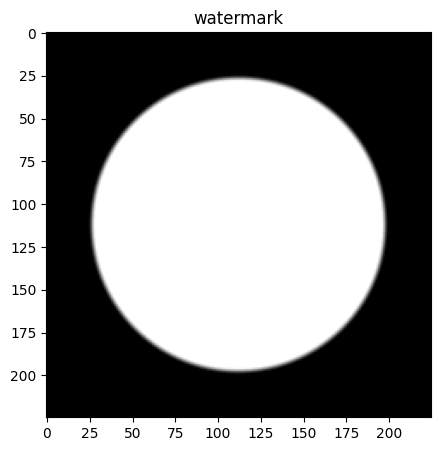

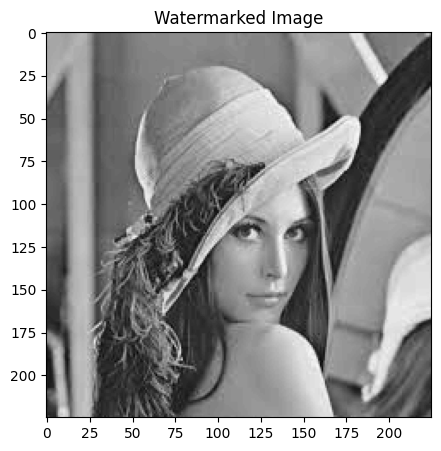

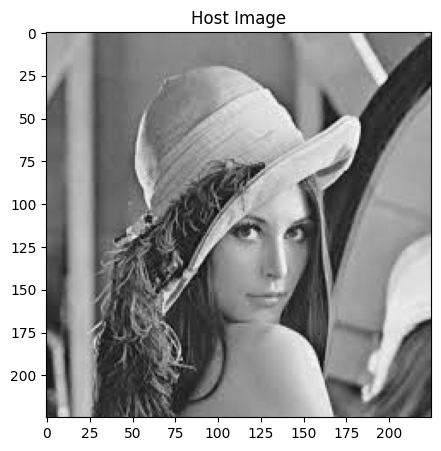

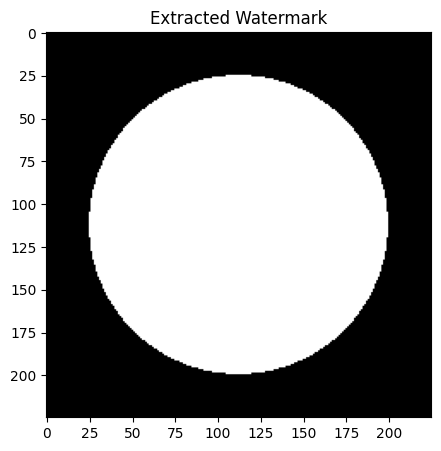

PSNR between original host image and watermarked image: 46.548660546541214


In [6]:
# Q = 3 is optimal for my images
Q = 3
host_image = cv2.imread(r'..\assets\lenaa.jpeg', cv2.IMREAD_GRAYSCALE)
# To ensure that all of the watermark and host images have same shape
'''h,w = host_image.shape
print(h)
print(w)'''

watermark_image = cv2.imread(r'..\assets\daire.png', cv2.IMREAD_GRAYSCALE)
# To ensure that all of the watermark and host images have same shape
'''h,w = watermark_image.shape
print(h)
print(w)'''

watermarked_image = embed_watermark(host_image, watermark_image, Q)
extracted_watermark = watermark_extractor(watermarked_image, Q)
# To ensure that all of the watermark and host images have same shape
'''h,w = extracted_watermark.shape
print(h)
print(w)'''

plt.figure(figsize=(5, 5))
plt.imshow(watermark_image, cmap='gray')
plt.title('watermark')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(watermarked_image, cmap='gray')
plt.title('Watermarked Image')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(host_image, cmap='gray')
plt.title('Host Image')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(extracted_watermark, cmap='gray')
plt.title('Extracted Watermark')
plt.show()


psnr_host_watermarked = psnr(host_image, watermarked_image)
print("PSNR between original host image and watermarked image:", psnr_host_watermarked)